# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [3]:
#!pip install loguru

In [54]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
fifa.shape

(18207, 37)

In [6]:
# Sua análise começa aqui.
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [7]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 37 columns):
Age                18207 non-null int64
Overall            18207 non-null int64
Potential          18207 non-null int64
Crossing           18159 non-null float64
Finishing          18159 non-null float64
HeadingAccuracy    18159 non-null float64
ShortPassing       18159 non-null float64
Volleys            18159 non-null float64
Dribbling          18159 non-null float64
Curve              18159 non-null float64
FKAccuracy         18159 non-null float64
LongPassing        18159 non-null float64
BallControl        18159 non-null float64
Acceleration       18159 non-null float64
SprintSpeed        18159 non-null float64
Agility            18159 non-null float64
Reactions          18159 non-null float64
Balance            18159 non-null float64
ShotPower          18159 non-null float64
Jumping            18159 non-null float64
Stamina            18159 non-null float64
Strength       

In [8]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [9]:
fifa.isnull().sum()

Age                 0
Overall             0
Potential           0
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
GKDiving           48
GKHandling         48
GKKicking          48
GKPositioning      48
GKReflexes         48
dtype: int64

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [10]:
#Precisa de dropar os NANs antes de utilizar o PCA
fifa.dropna(inplace=True)

In [11]:
#Teste

#Criando um PCA de 1 componente
pca = PCA(n_components=1)

#Aplicando o fit and transform do PCA criado aos dados do fifa
projected = pca.fit_transform(fifa)

#Retornando a variancia dos dados que consegue ser explicada pelo PCA de 1 componente
evr = pca.explained_variance_ratio_

#type(evr)
print(round(evr[0],3))

0.565


In [12]:
def q1():
    pca = PCA(n_components=1)
    projected = pca.fit_transform(fifa)
    evr = pca.explained_variance_ratio_
    
    return round(evr[0],3)

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [37]:
#Indica a porcentagem que se quer da variancia dos dados, utilizando o parametro n_components
pca_095 = PCA(n_components=0.95)

#Aplica o fit e transform para ver quantos componentes precisa para explicar 95% dos dados
X_reduced = pca_095.fit_transform(fifa)

X_reduced.shape[1]

15

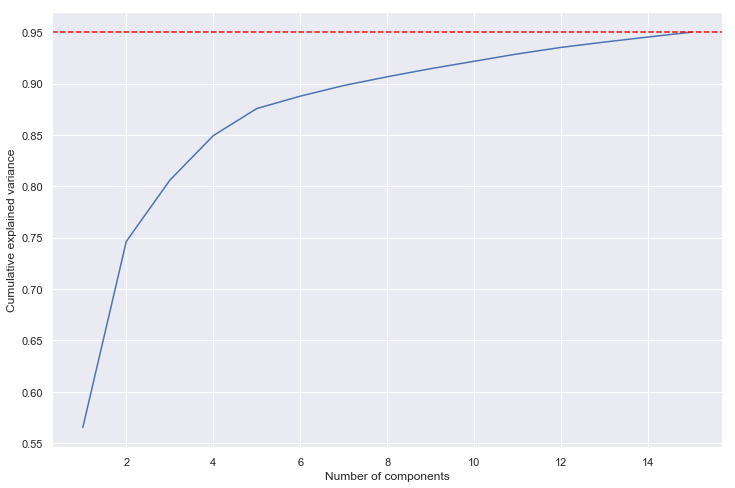

In [38]:
evr = pca_095.explained_variance_ratio_

g = sns.lineplot(np.arange(len(evr))+1, np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [39]:
def q2():
    #criando um pca fitando sem o paramentro n_components
    pca_095 = PCA(n_components=0.95)
    X_reduced = pca_095.fit_transform(fifa)

    return X_reduced.shape[1]

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [40]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [41]:
#Teste

#Criando PCA com 2 componentes
pca = PCA(n_components=2)

#Aplicando o fit e transform nos dados
projected = pca.fit_transform(fifa)

##### components_array, shape (n_components, n_features)
Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.

In [46]:
#Projetando a variavel x no PCA
pca.components_.dot(x)

array([186.55588031,  -6.59243177])

In [47]:
def q3():
    pca = PCA(n_components=2)
    projected = pca.fit_transform(fifa)
    return tuple(pca.components_.dot(x).round(3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [53]:
#Separando a variavel target e as labels
target = fifa['Overall']
label = fifa.drop(['Overall'],axis=1)

In [57]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

#Criando um modelo de regressao linear
lr = LinearRegression()

#Criando um RFE para selecionar as n_features melhores para o modelo
selector = RFE(lr, n_features_to_select=5, step=1)

#fittando o modelo com os dados de X,y
selector = selector.fit(label, target)

In [61]:
#Retorna True para as colunas selecionadas
selector.support_

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [62]:
#Faz com raking das colunas
selector.ranking_

array([ 1,  1, 17, 19,  7,  5, 32, 23, 24, 26, 27,  1, 12,  6, 28,  1, 13,
       21, 30,  9,  2, 25, 29, 31, 11, 18, 22,  3, 20, 15, 16,  4,  8, 10,
       14,  1])

In [71]:
label.columns[selector.support_]

Index(['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes'], dtype='object')

In [72]:
def q4():
    target = fifa['Overall']
    label = fifa.drop(['Overall'],axis=1)
    
    lr = LinearRegression()
    selector = RFE(lr, n_features_to_select=5, step=1)
    selector = selector.fit(label, target)
    
    return label.columns[selector.support_]